## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()
import sklearn.metrics
from importlib import reload
import time

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

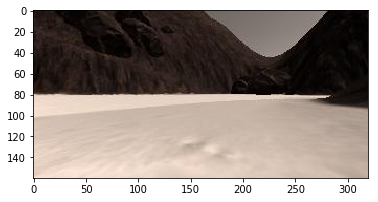

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

In [4]:
import perception
reload(perception)

<module 'perception' from '/Users/Pietras/Dropbox/udacity/RoboND-Rover-Project/code/perception.py'>

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

5


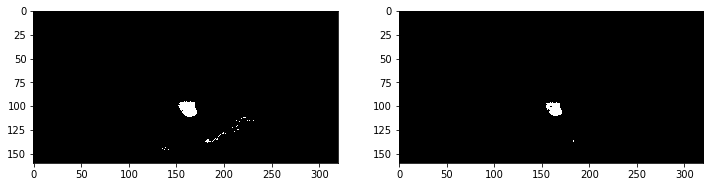

In [49]:
import perception
reload(perception)

# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock2.jpg'
img = mpimg.imread(example_rock)
rock_img = perception.rock_thresh(img)
im = cv2.inRange(img, (100, 100, 0), (250, 250, 90))
im[im.nonzero()] = 1
nudged = np.copy(im)
for (shift, axis) in [(1, 0), (1, 1), (-1, 0), (-1, 1)]:
  nudged += np.roll(im, shift, axis)

print(len(perception.rock_warped(rock_img).nonzero()[0]))
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(cv2.inRange(img, (100, 99, 0), (250, 250, 90)), cmap='gray')
plt.subplot(122)
plt.imshow(rock_img, cmap='gray')

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

0.5877424739393784


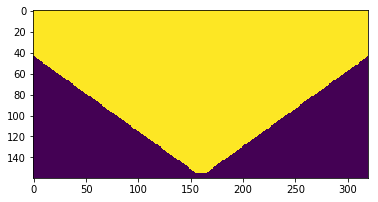

In [33]:
warped, mask = perception.perspect_transform(grid_img)
plt.imshow(warped)
plt.imshow(mask)
_, ang = perception.to_polar_coords(*perception.rover_coords(mask))
max_std = np.std(ang)
del ang
print(max_std)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

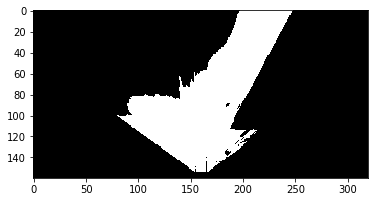

In [7]:
threshed = perception.color_thresh(warped)
obstacles = mask - threshed
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

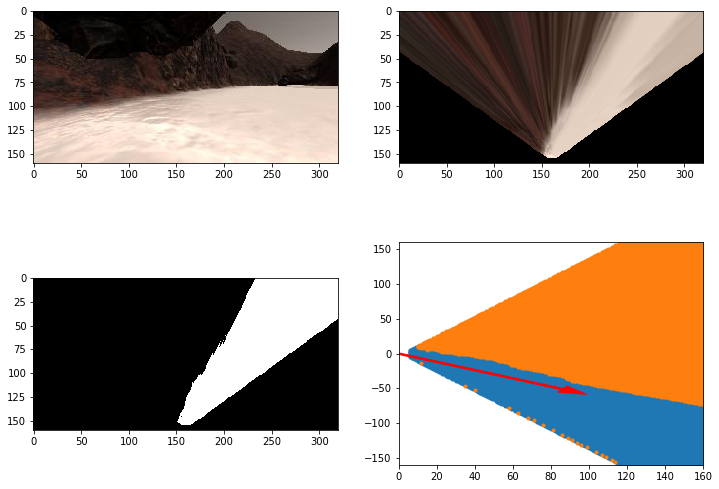

In [19]:
# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask = perception.perspect_transform(image)
threshed = perception.color_thresh(warped, (90, 150, 140))
obstacles = threshed - mask

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = perception.rover_coords(threshed)
dist, angles = perception.to_polar_coords(xpix, ypix)

mean_dir = perception.biased_mean(angles)

oxpix, oypix = perception.rover_coords(obstacles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.plot(oxpix, oypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

NameError: name 'max_std' is not defined

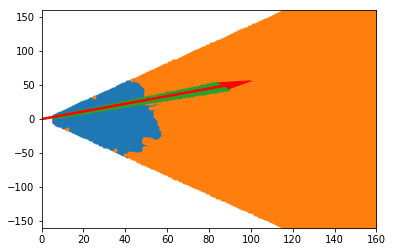

In [217]:
max_angle = np.pi/60
max_dist = 100
direction = mean_dir

plt.plot(xpix, ypix, '.')
plt.plot(oxpix, oypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
mx, my = np.int_(perception.rover_coords(mask))
dist, angl = perception.to_polar_coords(mx, my)
selection = (np.abs(angl - direction) < max_angle) & (dist < max_dist)
mx, my = mx[selection], my[selection]
plt.plot(mx, my, '.')

print(np.std(angles) / max_std)

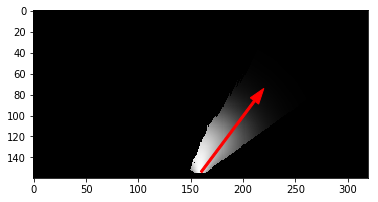

In [24]:
plt.imshow(perception.conf_img(threshed), cmap='gray')
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir + np.pi/2) + 160
y_arrow = arrow_length * np.sin(mean_dir + np.pi/2)
plt.arrow(160, 154, x_arrow - 160, y_arrow - 154, color='red', zorder=2, head_width=10, width=2)

## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [21]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
  def __init__(self):
    self.images = csv_img_list  
    self.xpos = df["X_Position"].values
    self.ypos = df["Y_Position"].values
    self.yaw = df["Yaw"].values
    self.pitch = df["Pitch"].values
    self.roll = df["Roll"].values
    self.count = 0 # This will be a running index

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()
df.columns


Index(['Path', 'SteerAngle', 'Throttle', 'Brake', 'Speed', 'X_Position',
       'Y_Position', 'Pitch', 'Yaw', 'Roll'],
      dtype='object')

## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [25]:
%%writefile viz.py
import perception
import numpy as np
import cv2

def draw_warped(rover):
  terrain_conf = perception.conf_img(rover.terrain)
  obstacles_conf = perception.conf_img(rover.obstacles)
  w, h = rover.terrain.shape
  img = np.zeros((w, h, 3))
  img[:, :, 2]= terrain_conf * 255
  img[:, :, 0] = obstacles_conf * 255
  return img

def draw_worldmap(Rover):
    # Create a scaled map for plotting and clean up obs/nav pixels a bit
  if np.max(Rover.worldmap[:,:,2]) > 0:
    nav_pix = Rover.worldmap[:,:,2] > 0
    navigable = Rover.worldmap[:,:,2] * (255 / np.mean(Rover.worldmap[nav_pix, 2]))
  else:
    navigable = Rover.worldmap[:,:,2]
  if np.max(Rover.worldmap[:,:,0]) > 0:
    obs_pix = Rover.worldmap[:,:,0] > 0
    obstacle = Rover.worldmap[:,:,0] * (255 / np.mean(Rover.worldmap[obs_pix, 0]))
  else:
    obstacle = Rover.worldmap[:,:,0]

  likely_nav = navigable >= obstacle
  obstacle[likely_nav] = 0
  # navigable[np.invert(likely_nav)] = 0
  plotmap = np.zeros_like(Rover.worldmap)
  plotmap[:, :, 0] = obstacle
  plotmap[:, :, 2] = navigable
  plotmap = plotmap.clip(0, 255)
  # Overlay obstacle and navigable terrain map with ground truth map
  map_add = cv2.addWeighted(plotmap, 1, Rover.ground_truth, 0.5, 0)
  
  # Check whether any rock detections are present in worldmap
  rock_world_pos = Rover.worldmap[:,:,1].nonzero()
  # If there are, we'll step through the known sample positions
  # to confirm whether detections are real
  samples_located = 0
  if rock_world_pos[0].any():
    rock_size = 2
    for idx in range(len(Rover.samples_pos[0])):
      test_rock_x = Rover.samples_pos[0][idx]
      test_rock_y = Rover.samples_pos[1][idx]
      rock_sample_dists = np.sqrt((test_rock_x - rock_world_pos[1])**2 + \
                (test_rock_y - rock_world_pos[0])**2)
      # If rocks were detected within 3 meters of known sample positions
      # consider it a success and plot the location of the known
      # sample on the map
      if np.min(rock_sample_dists) < 3:
        samples_located += 1
        map_add[test_rock_y-rock_size:test_rock_y+rock_size,
        test_rock_x-rock_size:test_rock_x+rock_size, :] = 255

  # Calculate some statistics on the map results
  # First get the total number of pixels in the navigable terrain map
  tot_nav_pix = np.float(len((plotmap[:,:,2].nonzero()[0])))
  # Next figure out how many of those correspond to ground truth pixels
  good_nav_pix = np.float(len(((plotmap[:,:,2] > 0) & (Rover.ground_truth[:,:,1] > 0)).nonzero()[0]))
  # Next find how many do not correspond to ground truth pixels
  bad_nav_pix = np.float(len(((plotmap[:,:,2] > 0) & (Rover.ground_truth[:,:,1] == 0)).nonzero()[0]))
  # Grab the total number of map pixels
  tot_map_pix = np.float(len((Rover.ground_truth[:,:,1].nonzero()[0])))
  # Calculate the percentage of ground truth map that has been successfully found
  perc_mapped = round(100*good_nav_pix/tot_map_pix, 1)
  # Calculate the number of good map pixel detections divided by total pixels
  # found to be navigable terrain
  if tot_nav_pix > 0:
    fidelity = round(100*good_nav_pix/(tot_nav_pix), 1)
  else:
    fidelity = 0
  # Flip the map for plotting so that the y-axis points upward in the display
#   map_add = np.flipud(map_add).astype(np.float32)
  # Add some text about map and rock sample detection results
  cv2.putText(map_add,"Time: "+str(np.round(Rover.total_time, 1))+' s', (0, 10),
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  cv2.putText(map_add,"Mapped: "+str(perc_mapped)+'%', (0, 25),
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  cv2.putText(map_add,"Fidelity: "+str(fidelity)+'%', (0, 40),
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  cv2.putText(map_add,"Rocks", (0, 55),
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  cv2.putText(map_add,"  Located: "+str(samples_located), (0, 70),
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  cv2.putText(map_add,"  Collected: "+str(Rover.samples_collected), (0, 85),
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  
  return map_add


Overwriting viz.py


In [26]:
import perception_step
import rover_state
import viz
import perception
reload(perception_step)
reload(rover_state)
reload(viz)
reload(perception)

def update_rover(Rover, data, img):
  ix = data.count
  if Rover.start_time == None:
    Rover.start_time = time.time()
    Rover.total_time = 0
  else:
    Rover.total_time = ix * 1/25
  Rover.pos = [data.xpos[ix], data.ypos[ix]]
  Rover.yaw = data.yaw[ix]
  Rover.roll = data.roll[ix]
  Rover.pitch = data.pitch[ix]
  Rover.img = img
  return Rover

rover = rover_state.RoverState()
  
def process_image(img):
  global rover
  rover = update_rover(rover, data, img)
  rover = perception_step.perception_step(rover)
    
  # First create a blank image (can be whatever shape you like)
  output_image = np.zeros((img.shape[0] + rover.worldmap.shape[0], img.shape[1]*2, 3))
  # Next you can populate regions of the image with various output
  # Here I'm putting the original image in the upper left hand corner
  output_image[0:img.shape[0], 0:img.shape[1]] = img
  
  # Flip map overlay so y-axis points upward and add to output_image 
  output_image[img.shape[0]:, 0:rover.worldmap.shape[1]] = viz.draw_worldmap(rover)
  output_image[0:img.shape[0], img.shape[1]:, :] = viz.draw_warped(rover)
  
  rock = perception.rock_thresh(img)
  for i in range(3):
    output_image[img.shape[0]:(img.shape[0] + rock.shape[0]), img.shape[1]:, i] = rock*255
  
#   # Then putting some text over the image
#   cv2.putText(output_image,
#             "       Helloo-o roll: %.2f, pitch: %.2f"%(rover.roll, rover.pitch), 
#             (20, 20), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
  
  if data.count < len(data.images) - 1:
    data.count += 1 # Keep track of the index in the Databucket()
  
  return output_image

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=20) # Note: output video will be sped up because 
                                      # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

from IPython.display import HTML
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls autoplay>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded_video.decode('ascii')))

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


 39%|███▉      | 112/284 [00:09<00:13, 12.61it/s]

Found a rock!!!
[102, 95] [[], []]
Found a rock!!!
[102, 100] [[], []]


 41%|████      | 116/284 [00:09<00:14, 11.88it/s]

Found a rock!!!
[102, 98] [[], []]
Found a rock!!!
[102, 98] [[], []]
Found a rock!!!
[102, 96] [[], []]


 42%|████▏     | 118/284 [00:09<00:14, 11.80it/s]

Found a rock!!!
[102, 97] [[], []]


 44%|████▎     | 124/284 [00:10<00:13, 12.22it/s]

Found a rock!!!
[102, 95] [[], []]
Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]


 44%|████▍     | 126/284 [00:10<00:13, 12.13it/s]

Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]


 45%|████▌     | 128/284 [00:10<00:13, 11.59it/s]

Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]


 46%|████▋     | 132/284 [00:11<00:12, 12.08it/s]

Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]
Found a rock!!!
[102, 96] [[], []]


 47%|████▋     | 134/284 [00:11<00:13, 10.75it/s]

Found a rock!!!
[101, 97] [[], []]


100%|██████████| 284/284 [00:21<00:00, 15.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 17.3 s, sys: 1.62 s, total: 18.9 s
Wall time: 22.3 s
